<a href="https://colab.research.google.com/github/yuuiwqy622/unsupervised-segmentation/blob/main/unsupervised_segmentation_isic2018_unet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
%tensorflow_version 1.x
!pip install keras==2.1.5

TensorFlow 1.x selected.


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import os
from PIL import Image
import keras
from keras.models import Model
from keras.layers import Conv2D, MaxPooling2D, Input, Conv2DTranspose, Concatenate, BatchNormalization, UpSampling2D
from keras.layers import  Dropout, Activation
from keras.optimizers import Adam, SGD
from keras.layers.advanced_activations import LeakyReLU
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from keras import backend as K
from keras.utils import plot_model
import tensorflow as tf
import glob
import random
import cv2
from random import shuffle

Using TensorFlow backend.


In [ ]:
def image_generator(files, batch_size = 32, sz = (256, 256)):
  
  while True: 
    
    #extract a random batch 
    batch = np.random.choice(files, size = batch_size)    
    
    #variables for collecting batches of inputs and outputs 
    batch_x = []
    batch_y = []
    
    
    for f in batch:
        #get the masks. Note that masks are png files 
        mask = Image.open(f'synth-masks/{f[:-4]}.png')
        mask = np.array(mask.resize(sz))


        #preprocess the mask 
        mask[mask > 0] = 1
        # mask[mask != 0 ] = 1
        
        batch_y.append(mask)

        #preprocess the raw images 
        raw = Image.open(f'synth-images/{f}')
        # raw = raw.resize(sz)
        raw = np.array(raw)

        #check the number of channels because some of the images are RGBA or GRAY
        if len(raw.shape) == 2:
          raw = np.stack((raw,)*3, axis=-1)

        else:
          raw = raw[:,:,0:3]

        batch_x.append(raw)

    #preprocess a batch of images and masks 
    batch_x = np.array(batch_x)/255.
    batch_y = np.array(batch_y)
    batch_y = np.expand_dims(batch_y,3)

    yield (batch_x, batch_y)

In [ ]:
batch_size = 1

all_files = os.listdir('synth-images')
shuffle(all_files)

split = int(0.95 * len(all_files))

#split into training and testing
train_files = all_files[0:split]
test_files  = all_files[split:]

train_generator = image_generator(train_files, batch_size = batch_size)
print(type(train_generator))
test_generator  = image_generator(test_files, batch_size = batch_size)

<class 'generator'>


In [ ]:
x, y= next(train_generator)

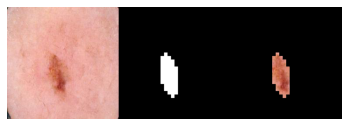

In [ ]:
plt.axis('off')
img = x[0]
msk = y[0].squeeze()
msk = np.stack((msk,)*3, axis=-1)

plt.imshow( np.concatenate([img, msk, img*msk], axis = 1))

In [ ]:
def mean_iou(y_true, y_pred):
    yt0 = y_true[:,:,:,0]
    yp0 = K.cast(y_pred[:,:,:,0] > 0.5, 'float32')
    inter = tf.count_nonzero(tf.logical_and(tf.equal(yt0, 1), tf.equal(yp0, 1)))
    union = tf.count_nonzero(tf.add(yt0, yp0))
    iou = tf.where(tf.equal(union, 0), 1., tf.cast(inter/union, 'float32'))
    return iou

In [ ]:
def unet(sz = (256, 256, 3)):
  x = Input(sz)
  inputs = x
  
  #down sampling 
  f = 8
  layers = []
  
  for i in range(0, 6):
    x = Conv2D(f, 3, activation='relu', padding='same') (x)
    x = Conv2D(f, 3, activation='relu', padding='same') (x)
    layers.append(x)
    x = MaxPooling2D() (x)
    f = f*2
  ff2 = 64 
  
  #bottleneck 
  j = len(layers) - 1
  x = Conv2D(f, 3, activation='relu', padding='same') (x)
  x = Conv2D(f, 3, activation='relu', padding='same') (x)
  x = Conv2DTranspose(ff2, 2, strides=(2, 2), padding='same') (x)
  x = Concatenate(axis=3)([x, layers[j]])
  j = j -1 
  
  #upsampling 
  for i in range(0, 5):
    ff2 = ff2//2
    f = f // 2 
    x = Conv2D(f, 3, activation='relu', padding='same') (x)
    x = Conv2D(f, 3, activation='relu', padding='same') (x)
    x = Conv2DTranspose(ff2, 2, strides=(2, 2), padding='same') (x)
    x = Concatenate(axis=3)([x, layers[j]])
    j = j -1 
    
  
  #classification 
  x = Conv2D(f, 3, activation='relu', padding='same') (x)
  x = Conv2D(f, 3, activation='relu', padding='same') (x)
  outputs = Conv2D(1, 1, activation='sigmoid') (x)
  
  #model creation 
  model = Model(inputs=[inputs], outputs=[outputs])
  model.compile(optimizer = 'rmsprop', loss = 'binary_crossentropy', metrics = [mean_iou])
  
  return model

In [ ]:
model = unet()







Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [ ]:
def build_callbacks():
        checkpointer = ModelCheckpoint(filepath='unet.h5', verbose=0, save_best_only=True, save_weights_only=True)
        callbacks = [checkpointer, PlotLearning()]
        return callbacks

# inheritance for training process plot 
class PlotLearning(keras.callbacks.Callback):

    def on_train_begin(self, logs={}):
        self.i = 0
        self.x = []
        self.losses = []
        self.val_losses = []
        self.acc = []
        self.val_acc = []
        #self.fig = plt.figure()
        self.logs = []
    def on_epoch_end(self, epoch, logs={}):
        self.logs.append(logs)
        self.x.append(self.i)
        self.losses.append(logs.get('loss'))
        self.val_losses.append(logs.get('val_loss'))
        self.acc.append(logs.get('mean_iou'))
        self.val_acc.append(logs.get('val_mean_iou'))
        self.i += 1
        print('i=',self.i,'loss=',logs.get('loss'),'val_loss=',logs.get('val_loss'),'mean_iou=',logs.get('mean_iou'),'val_mean_iou=',logs.get('val_mean_iou'))
        
        #choose a random test image and preprocess
        path = np.random.choice(test_files)
        raw = Image.open(f'synth-images/{path}')
        raw = np.array(raw.resize((256, 256)))/255.
        raw = raw[:,:,0:3]
        
        #predict the mask 
        pred = model.predict(np.expand_dims(raw, 0))
        
        #mask post-processing 
        msk  = pred.squeeze()
        msk = np.stack((msk,)*3, axis=-1)
        msk[msk >= 0.5] = 1 
        msk[msk < 0.5] = 0 
        
        #show the mask and the segmented image 
        combined = np.concatenate([raw, msk, raw* msk], axis = 1)
        plt.axis('off')
        plt.imshow(combined)
        plt.show()

train_steps: 95
test_steps: 5
Epoch 1/70
 - 2s - loss: 0.1404 - mean_iou: 0.7285 - val_loss: 0.1948 - val_mean_iou: 0.8028
i= 1 loss= 0.14038322209135481 val_loss= 0.19479845762252807 mean_iou= 0.7285383221742354 val_mean_iou= 0.8028333067893982


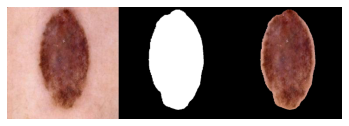

Epoch 2/70
 - 2s - loss: 0.1464 - mean_iou: 0.7198 - val_loss: 0.1057 - val_mean_iou: 0.8752
i= 2 loss= 0.14644341876632289 val_loss= 0.10570308715105056 mean_iou= 0.7198476961960918 val_mean_iou= 0.8752267956733704


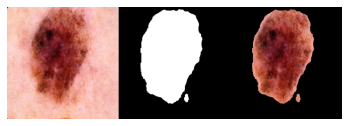

Epoch 3/70
 - 2s - loss: 0.1353 - mean_iou: 0.7785 - val_loss: 0.1687 - val_mean_iou: 0.8147
i= 3 loss= 0.13533214058138823 val_loss= 0.1687000259757042 mean_iou= 0.7785398994621477 val_mean_iou= 0.8146674275398255


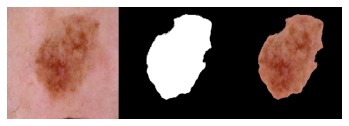

Epoch 4/70
 - 2s - loss: 0.1201 - mean_iou: 0.7321 - val_loss: 0.1564 - val_mean_iou: 0.8383
i= 4 loss= 0.12011797345782581 val_loss= 0.15638177767395972 mean_iou= 0.7320619933699307 val_mean_iou= 0.8382948994636535


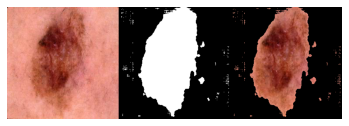

Epoch 5/70
 - 2s - loss: 0.1451 - mean_iou: 0.7421 - val_loss: 0.0961 - val_mean_iou: 0.8718
i= 5 loss= 0.14508168622851372 val_loss= 0.09609531611204147 mean_iou= 0.7421038004520693 val_mean_iou= 0.8717794775962829


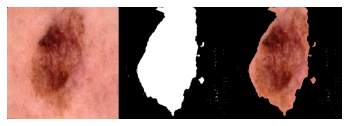

Epoch 6/70
 - 2s - loss: 0.1068 - mean_iou: 0.7726 - val_loss: 0.0945 - val_mean_iou: 0.8869
i= 6 loss= 0.1067519315077286 val_loss= 0.09447894543409348 mean_iou= 0.7726334414984051 val_mean_iou= 0.886877965927124


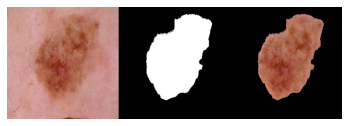

Epoch 7/70
 - 2s - loss: 0.1237 - mean_iou: 0.7660 - val_loss: 0.1425 - val_mean_iou: 0.8304
i= 7 loss= 0.12370094527539453 val_loss= 0.14250062853097917 mean_iou= 0.7660393310220618 val_mean_iou= 0.8304237723350525


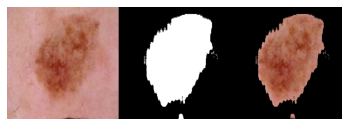

Epoch 8/70
 - 2s - loss: 0.1063 - mean_iou: 0.7799 - val_loss: 0.0800 - val_mean_iou: 0.8895
i= 8 loss= 0.10627583198641476 val_loss= 0.07996772080659867 mean_iou= 0.7798985904768894 val_mean_iou= 0.8895461678504943


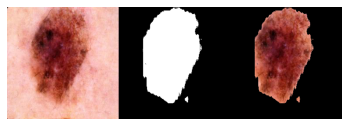

Epoch 9/70
 - 2s - loss: 0.1061 - mean_iou: 0.8056 - val_loss: 0.1095 - val_mean_iou: 0.8796
i= 9 loss= 0.10607135935049308 val_loss= 0.10945907309651375 mean_iou= 0.8055510308397443 val_mean_iou= 0.8795589566230774


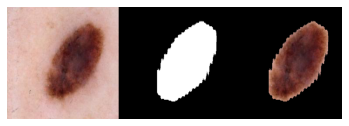

Epoch 10/70
 - 2s - loss: 0.1078 - mean_iou: 0.7802 - val_loss: 0.1618 - val_mean_iou: 0.8555
i= 10 loss= 0.10783640448200076 val_loss= 0.16182832717895507 mean_iou= 0.7802180752942437 val_mean_iou= 0.855519711971283


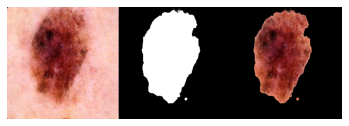

Epoch 11/70
 - 2s - loss: 0.1119 - mean_iou: 0.7784 - val_loss: 0.0760 - val_mean_iou: 0.8958
i= 11 loss= 0.1118655415545953 val_loss= 0.0760324776172638 mean_iou= 0.7784242447857794 val_mean_iou= 0.8957786917686462


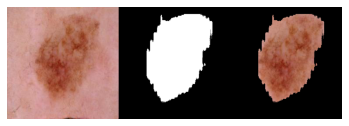

Epoch 12/70
 - 2s - loss: 0.1075 - mean_iou: 0.8015 - val_loss: 0.0949 - val_mean_iou: 0.9092
i= 12 loss= 0.10751145317366248 val_loss= 0.09494137018918991 mean_iou= 0.8015400899083991 val_mean_iou= 0.9091719627380371


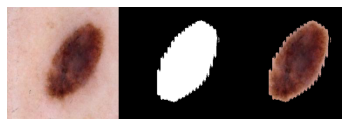

Epoch 13/70
 - 2s - loss: 0.1118 - mean_iou: 0.8161 - val_loss: 0.0990 - val_mean_iou: 0.8688
i= 13 loss= 0.11178258194735176 val_loss= 0.09896611869335174 mean_iou= 0.8160939445584326 val_mean_iou= 0.8688201665878296


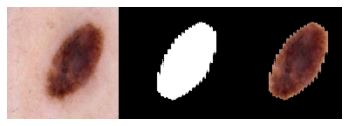

Epoch 14/70
 - 2s - loss: 0.1054 - mean_iou: 0.8004 - val_loss: 0.1152 - val_mean_iou: 0.8665
i= 14 loss= 0.10540853005490805 val_loss= 0.11521466672420502 mean_iou= 0.8004235187643453 val_mean_iou= 0.866498875617981


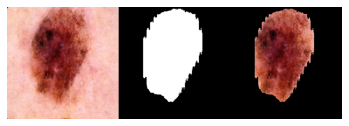

Epoch 15/70
 - 2s - loss: 0.1012 - mean_iou: 0.7997 - val_loss: 0.2271 - val_mean_iou: 0.8100
i= 15 loss= 0.10123751229165416 val_loss= 0.22710235714912413 mean_iou= 0.7996798927846708 val_mean_iou= 0.809969139099121


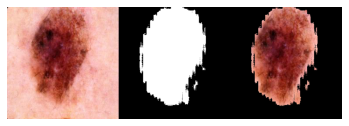

Epoch 16/70
 - 2s - loss: 0.0827 - mean_iou: 0.8151 - val_loss: 0.0594 - val_mean_iou: 0.9130
i= 16 loss= 0.08270764609700755 val_loss= 0.059400124847888945 mean_iou= 0.8151405359569349 val_mean_iou= 0.9130203723907471


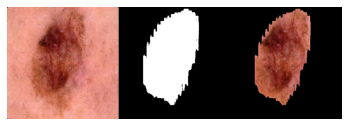

Epoch 17/70
 - 2s - loss: 0.0981 - mean_iou: 0.8160 - val_loss: 0.1876 - val_mean_iou: 0.7882
i= 17 loss= 0.09810459892216482 val_loss= 0.1875874310731888 mean_iou= 0.8160108095721195 val_mean_iou= 0.7882014870643616


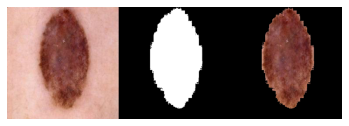

Epoch 18/70
 - 2s - loss: 0.1022 - mean_iou: 0.8080 - val_loss: 0.0576 - val_mean_iou: 0.9240
i= 18 loss= 0.10220376900152156 val_loss= 0.05760910138487816 mean_iou= 0.807957135689886 val_mean_iou= 0.9240431427955628


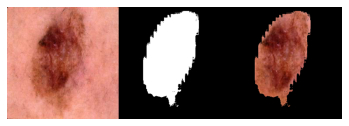

Epoch 19/70
 - 2s - loss: 0.0597 - mean_iou: 0.8600 - val_loss: 0.0970 - val_mean_iou: 0.8870
i= 19 loss= 0.059681475358574015 val_loss= 0.09701122343540192 mean_iou= 0.8599556703316538 val_mean_iou= 0.8869505167007447


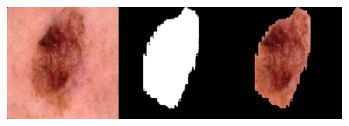

Epoch 20/70
 - 2s - loss: 0.0939 - mean_iou: 0.8187 - val_loss: 0.1532 - val_mean_iou: 0.8783
i= 20 loss= 0.09385968283995201 val_loss= 0.15318628996610642 mean_iou= 0.8187324674505937 val_mean_iou= 0.8782846450805664


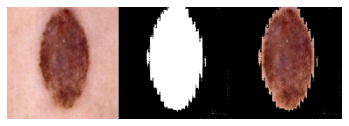

Epoch 21/70
 - 2s - loss: 0.0822 - mean_iou: 0.8253 - val_loss: 0.1017 - val_mean_iou: 0.8721
i= 21 loss= 0.08215317329097735 val_loss= 0.10174881070852279 mean_iou= 0.8252760830678438 val_mean_iou= 0.8720994234085083


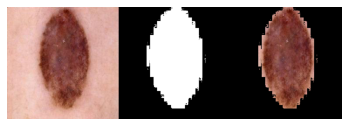

Epoch 22/70
 - 2s - loss: 0.0884 - mean_iou: 0.8411 - val_loss: 0.0381 - val_mean_iou: 0.9459
i= 22 loss= 0.08836239637120774 val_loss= 0.03806000500917435 mean_iou= 0.8411226165922064 val_mean_iou= 0.945900559425354


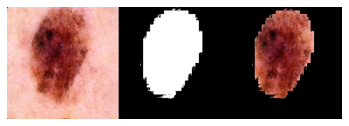

Epoch 23/70
 - 2s - loss: 0.0816 - mean_iou: 0.8388 - val_loss: 0.1212 - val_mean_iou: 0.8765
i= 23 loss= 0.08159729126644762 val_loss= 0.12115017175674439 mean_iou= 0.8388202908399858 val_mean_iou= 0.8764755964279175


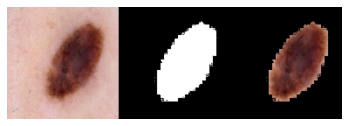

Epoch 24/70
 - 2s - loss: 0.0795 - mean_iou: 0.8451 - val_loss: 0.1868 - val_mean_iou: 0.8301
i= 24 loss= 0.07947648688170471 val_loss= 0.1868229828774929 mean_iou= 0.8451439304571403 val_mean_iou= 0.8301107525825501


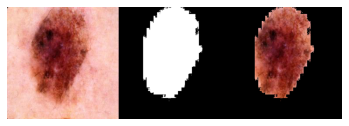

Epoch 25/70
 - 2s - loss: 0.0612 - mean_iou: 0.8517 - val_loss: 0.2272 - val_mean_iou: 0.8588
i= 25 loss= 0.06123873884544561 val_loss= 0.22716874182224273 mean_iou= 0.8517339295462558 val_mean_iou= 0.8588477969169617


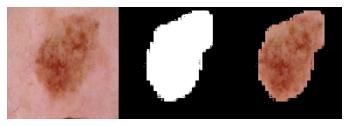

Epoch 26/70
 - 2s - loss: 0.0664 - mean_iou: 0.8471 - val_loss: 0.0688 - val_mean_iou: 0.9006
i= 26 loss= 0.06640418709108704 val_loss= 0.068824452906847 mean_iou= 0.8470927912937968 val_mean_iou= 0.9005999565124512


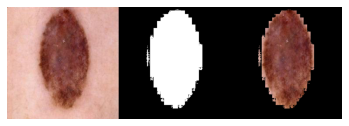

Epoch 27/70
 - 2s - loss: 0.0551 - mean_iou: 0.8470 - val_loss: 0.0955 - val_mean_iou: 0.8915
i= 27 loss= 0.055101443694806414 val_loss= 0.09552150964736938 mean_iou= 0.8470247177701248 val_mean_iou= 0.8914793729782104


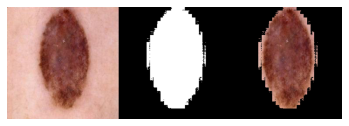

Epoch 28/70
 - 2s - loss: 0.0927 - mean_iou: 0.8530 - val_loss: 0.9551 - val_mean_iou: 0.6896
i= 28 loss= 0.09267890149433362 val_loss= 0.9551242172718049 mean_iou= 0.8530092035469256 val_mean_iou= 0.6896016001701355


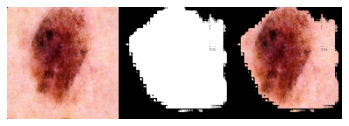

Epoch 29/70
 - 2s - loss: 0.0581 - mean_iou: 0.8681 - val_loss: 0.0629 - val_mean_iou: 0.9210
i= 29 loss= 0.0581494172250754 val_loss= 0.06289234459400177 mean_iou= 0.8681379741743991 val_mean_iou= 0.9209730744361877


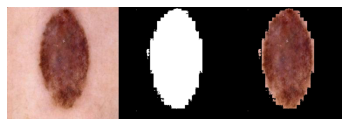

Epoch 30/70
 - 2s - loss: 0.0777 - mean_iou: 0.8483 - val_loss: 0.0783 - val_mean_iou: 0.9056
i= 30 loss= 0.07769437182302538 val_loss= 0.07832600325345992 mean_iou= 0.8482538009944715 val_mean_iou= 0.9055928349494934


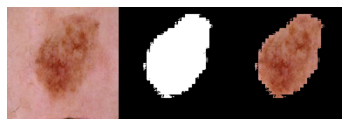

Epoch 31/70
 - 2s - loss: 0.0515 - mean_iou: 0.8707 - val_loss: 0.0425 - val_mean_iou: 0.9532
i= 31 loss= 0.05149977182675349 val_loss= 0.04248296283185482 mean_iou= 0.8706880418877853 val_mean_iou= 0.9532059907913208


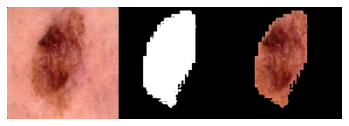

Epoch 32/70
 - 2s - loss: 0.0692 - mean_iou: 0.8703 - val_loss: 0.0784 - val_mean_iou: 0.8990
i= 32 loss= 0.06920517272266903 val_loss= 0.07835626155138016 mean_iou= 0.8703156891622041 val_mean_iou= 0.8990107417106629


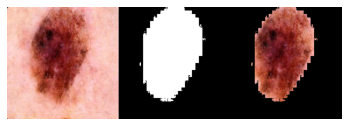

Epoch 33/70
 - 2s - loss: 0.1016 - mean_iou: 0.8483 - val_loss: 0.1134 - val_mean_iou: 0.8835
i= 33 loss= 0.10164737282811027 val_loss= 0.11341633573174477 mean_iou= 0.848329790838455 val_mean_iou= 0.8834911584854126


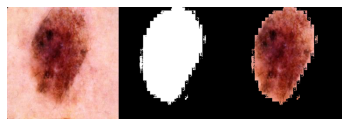

Epoch 34/70
 - 2s - loss: 0.0505 - mean_iou: 0.8572 - val_loss: 0.0928 - val_mean_iou: 0.8983
i= 34 loss= 0.05051121379395849 val_loss= 0.09284793734550476 mean_iou= 0.8571643465443661 val_mean_iou= 0.8982958912849426


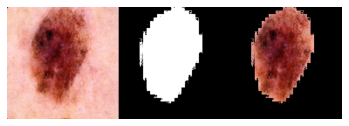

Epoch 35/70
 - 2s - loss: 0.0548 - mean_iou: 0.8856 - val_loss: 0.0904 - val_mean_iou: 0.8976
i= 35 loss= 0.054810881389206964 val_loss= 0.09036547243595124 mean_iou= 0.8856417988476001 val_mean_iou= 0.8975923895835877


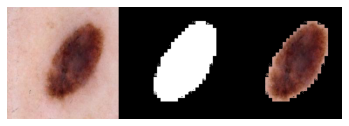

Epoch 36/70
 - 2s - loss: 0.0531 - mean_iou: 0.8848 - val_loss: 0.0720 - val_mean_iou: 0.9143
i= 36 loss= 0.05310541133543378 val_loss= 0.07201722860336304 mean_iou= 0.8848298505732888 val_mean_iou= 0.9143114209175109


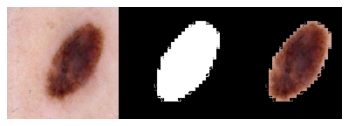

Epoch 37/70
 - 2s - loss: 0.0505 - mean_iou: 0.8913 - val_loss: 0.1358 - val_mean_iou: 0.8636
i= 37 loss= 0.05054095984485588 val_loss= 0.13579578027129174 mean_iou= 0.8913136055594997 val_mean_iou= 0.8636258006095886


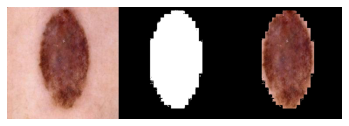

Epoch 38/70
 - 2s - loss: 0.0537 - mean_iou: 0.8865 - val_loss: 0.1018 - val_mean_iou: 0.8795
i= 38 loss= 0.053679529273588406 val_loss= 0.10178881585597992 mean_iou= 0.8864794089605934 val_mean_iou= 0.8795219540596009


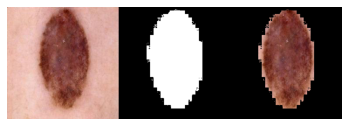

Epoch 39/70
 - 2s - loss: 0.0558 - mean_iou: 0.8784 - val_loss: 0.1102 - val_mean_iou: 0.8740
i= 39 loss= 0.055830577241354866 val_loss= 0.11019585728645324 mean_iou= 0.8784157969449696 val_mean_iou= 0.8739516735076904


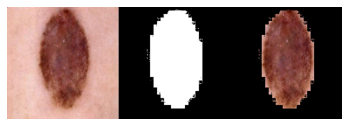

Epoch 40/70
 - 2s - loss: 0.0400 - mean_iou: 0.8891 - val_loss: 0.1276 - val_mean_iou: 0.8702
i= 40 loss= 0.03997498645300144 val_loss= 0.12760666608810425 mean_iou= 0.8890712223554912 val_mean_iou= 0.8702214479446411


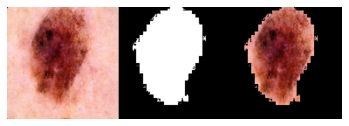

Epoch 41/70
 - 2s - loss: 0.0517 - mean_iou: 0.8696 - val_loss: 0.0783 - val_mean_iou: 0.9205
i= 41 loss= 0.051719848772412855 val_loss= 0.07825303971767425 mean_iou= 0.8696121683246211 val_mean_iou= 0.9205141544342041


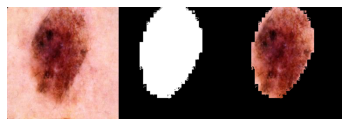

Epoch 42/70
 - 2s - loss: 0.0353 - mean_iou: 0.8978 - val_loss: 0.2399 - val_mean_iou: 0.8658
i= 42 loss= 0.0353402509207004 val_loss= 0.23988628685474395 mean_iou= 0.8977987590589022 val_mean_iou= 0.8657731890678406


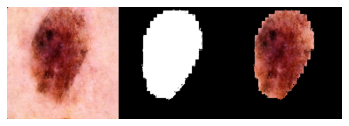

Epoch 43/70
 - 2s - loss: 0.0430 - mean_iou: 0.8949 - val_loss: 0.0938 - val_mean_iou: 0.8805
i= 43 loss= 0.0430032237677982 val_loss= 0.09379072338342667 mean_iou= 0.8948996333699477 val_mean_iou= 0.8805489182472229


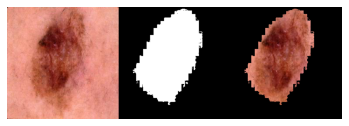

Epoch 44/70
 - 2s - loss: 0.0616 - mean_iou: 0.8843 - val_loss: 0.0524 - val_mean_iou: 0.9369
i= 44 loss= 0.061562561547677766 val_loss= 0.052362849563360216 mean_iou= 0.8843036011645669 val_mean_iou= 0.9368545174598694


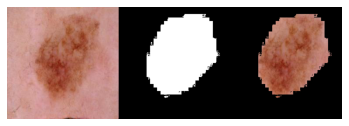

Epoch 45/70
 - 2s - loss: 0.0526 - mean_iou: 0.8826 - val_loss: 0.0619 - val_mean_iou: 0.9301
i= 45 loss= 0.05264878568092459 val_loss= 0.06189961954951286 mean_iou= 0.8826131061503761 val_mean_iou= 0.9301033258438111


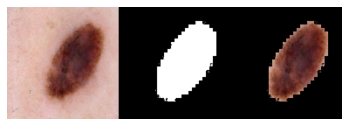

Epoch 46/70
 - 2s - loss: 0.0428 - mean_iou: 0.8919 - val_loss: 0.1195 - val_mean_iou: 0.8889
i= 46 loss= 0.04278959712797874 val_loss= 0.11946037262678147 mean_iou= 0.8918623710933484 val_mean_iou= 0.8888528943061829


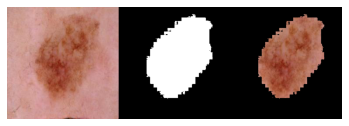

Epoch 47/70
 - 2s - loss: 0.0519 - mean_iou: 0.9054 - val_loss: 0.1042 - val_mean_iou: 0.9130
i= 47 loss= 0.05192979735959517 val_loss= 0.10417024120688438 mean_iou= 0.905395474873091 val_mean_iou= 0.912980580329895


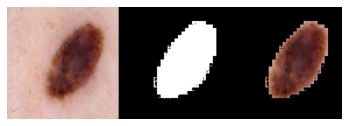

Epoch 48/70
 - 2s - loss: 0.0335 - mean_iou: 0.9044 - val_loss: 0.0902 - val_mean_iou: 0.9001
i= 48 loss= 0.03352297708196075 val_loss= 0.09024249278008938 mean_iou= 0.9043635587943227 val_mean_iou= 0.9000726103782654


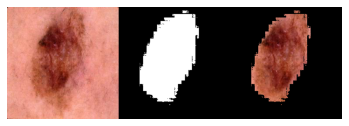

Epoch 49/70
 - 2s - loss: 0.0341 - mean_iou: 0.9133 - val_loss: 0.1035 - val_mean_iou: 0.9149
i= 49 loss= 0.034069981626970204 val_loss= 0.10353390350937844 mean_iou= 0.9132767627113744 val_mean_iou= 0.9149463295936584


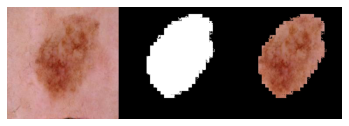

Epoch 50/70
 - 2s - loss: 0.0344 - mean_iou: 0.9085 - val_loss: 0.0825 - val_mean_iou: 0.9065
i= 50 loss= 0.034370250593086606 val_loss= 0.08246784955263138 mean_iou= 0.9085114905708714 val_mean_iou= 0.9064847707748414


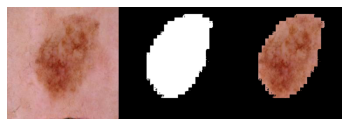

Epoch 51/70
 - 2s - loss: 0.0269 - mean_iou: 0.9186 - val_loss: 0.0736 - val_mean_iou: 0.9133
i= 51 loss= 0.026871432868861837 val_loss= 0.07359385639429092 mean_iou= 0.9185525705939845 val_mean_iou= 0.9133105754852295


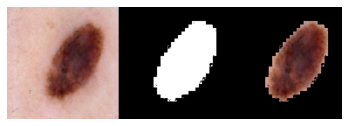

Epoch 52/70
 - 2s - loss: 0.0318 - mean_iou: 0.8977 - val_loss: 0.1520 - val_mean_iou: 0.9054
i= 52 loss= 0.0317921418500574 val_loss= 0.15197274684906006 mean_iou= 0.8977317477527418 val_mean_iou= 0.9053566098213196


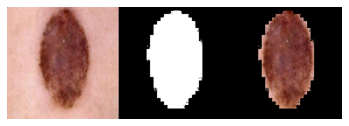

Epoch 53/70
 - 2s - loss: 0.0338 - mean_iou: 0.9197 - val_loss: 0.1082 - val_mean_iou: 0.9160
i= 53 loss= 0.0338304892525469 val_loss= 0.10822516977787018 mean_iou= 0.9196878997903121 val_mean_iou= 0.9159681081771851


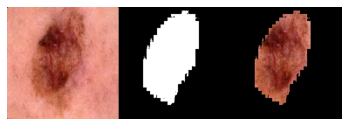

Epoch 54/70
 - 2s - loss: 0.0366 - mean_iou: 0.9197 - val_loss: 0.2157 - val_mean_iou: 0.8382
i= 54 loss= 0.036606151635121355 val_loss= 0.21569997370243071 mean_iou= 0.9196555275666086 val_mean_iou= 0.8382018208503723


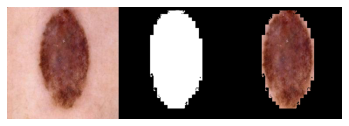

Epoch 55/70
 - 2s - loss: 0.0315 - mean_iou: 0.9297 - val_loss: 0.1730 - val_mean_iou: 0.8700
i= 55 loss= 0.03150496651957694 val_loss= 0.17304114550352095 mean_iou= 0.9297394200375205 val_mean_iou= 0.8700235486030579


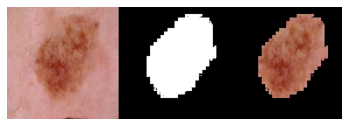

Epoch 56/70
 - 2s - loss: 0.0301 - mean_iou: 0.9313 - val_loss: 0.0771 - val_mean_iou: 0.9227
i= 56 loss= 0.030064311025566177 val_loss= 0.07714507281780243 mean_iou= 0.9312898573122527 val_mean_iou= 0.9226579666137695


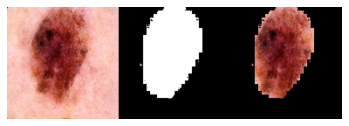

Epoch 57/70
 - 2s - loss: 0.0323 - mean_iou: 0.9246 - val_loss: 0.0706 - val_mean_iou: 0.9160
i= 57 loss= 0.03230597325355599 val_loss= 0.07055395022034645 mean_iou= 0.9246085185753672 val_mean_iou= 0.9159825801849365


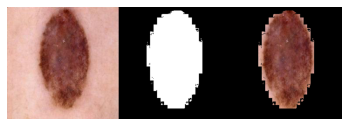

Epoch 58/70
 - 2s - loss: 0.0245 - mean_iou: 0.9331 - val_loss: 0.0692 - val_mean_iou: 0.9487
i= 58 loss= 0.024545749368783284 val_loss= 0.06924114003777504 mean_iou= 0.9330813370252911 val_mean_iou= 0.9487393021583557


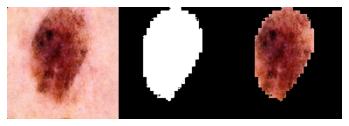

Epoch 59/70
 - 2s - loss: 0.0321 - mean_iou: 0.9205 - val_loss: 0.0885 - val_mean_iou: 0.9240
i= 59 loss= 0.032098024353188905 val_loss= 0.08846993409097195 mean_iou= 0.9204624750112232 val_mean_iou= 0.9240070939064026


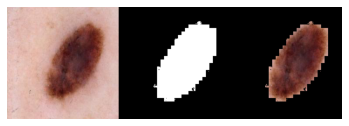

Epoch 60/70
 - 2s - loss: 0.0234 - mean_iou: 0.9336 - val_loss: 0.0917 - val_mean_iou: 0.9209
i= 60 loss= 0.023368831236209524 val_loss= 0.0916980542242527 mean_iou= 0.933613489803515 val_mean_iou= 0.9208639860153198


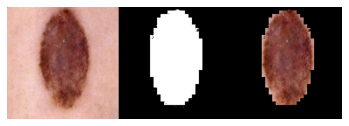

Epoch 61/70
 - 2s - loss: 0.0238 - mean_iou: 0.9339 - val_loss: 0.0681 - val_mean_iou: 0.9408
i= 61 loss= 0.023832525741799098 val_loss= 0.06814644634723663 mean_iou= 0.9339128117812308 val_mean_iou= 0.9407770752906799


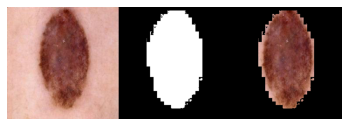

Epoch 62/70
 - 2s - loss: 0.0383 - mean_iou: 0.9220 - val_loss: 0.1116 - val_mean_iou: 0.9055
i= 62 loss= 0.03828077906693675 val_loss= 0.11156124100089074 mean_iou= 0.9220489555283596 val_mean_iou= 0.9054998159408569


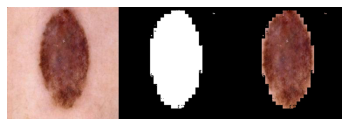

Epoch 63/70
 - 2s - loss: 0.0260 - mean_iou: 0.9418 - val_loss: 0.1152 - val_mean_iou: 0.9088
i= 63 loss= 0.025967887217963212 val_loss= 0.11517211571335792 mean_iou= 0.9417606152986225 val_mean_iou= 0.9087582707405091


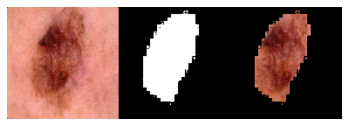

Epoch 64/70
 - 2s - loss: 0.0261 - mean_iou: 0.9355 - val_loss: 0.1073 - val_mean_iou: 0.8888
i= 64 loss= 0.026093737876630926 val_loss= 0.10727454721927643 mean_iou= 0.9355343693181088 val_mean_iou= 0.8888014435768128


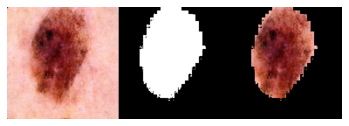

Epoch 65/70
 - 2s - loss: 0.0225 - mean_iou: 0.9334 - val_loss: 0.1745 - val_mean_iou: 0.8851
i= 65 loss= 0.02251711186805838 val_loss= 0.17454270124435425 mean_iou= 0.9333794976535597 val_mean_iou= 0.8850945115089417


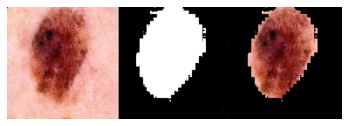

Epoch 66/70
 - 2s - loss: 0.0246 - mean_iou: 0.9423 - val_loss: 0.1230 - val_mean_iou: 0.9163
i= 66 loss= 0.024562250565443384 val_loss= 0.12295575439929962 mean_iou= 0.9423260073912771 val_mean_iou= 0.9162937760353088


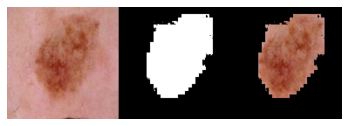

Epoch 67/70
 - 2s - loss: 0.0201 - mean_iou: 0.9436 - val_loss: 0.1064 - val_mean_iou: 0.9053
i= 67 loss= 0.020141777511391984 val_loss= 0.10643596947193146 mean_iou= 0.9435651603497957 val_mean_iou= 0.9052589654922485


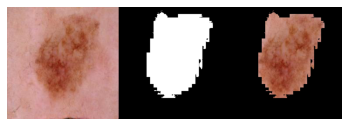

Epoch 68/70
 - 2s - loss: 0.0173 - mean_iou: 0.9513 - val_loss: 0.1835 - val_mean_iou: 0.8923
i= 68 loss= 0.017255150164036375 val_loss= 0.18346819877624512 mean_iou= 0.9512803780405145 val_mean_iou= 0.8923319101333618


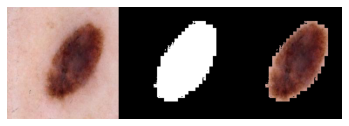

Epoch 69/70
 - 2s - loss: 0.0195 - mean_iou: 0.9438 - val_loss: 0.1493 - val_mean_iou: 0.9014
i= 69 loss= 0.019529356535426097 val_loss= 0.14931100830435753 mean_iou= 0.9438105921996267 val_mean_iou= 0.9013534307479858


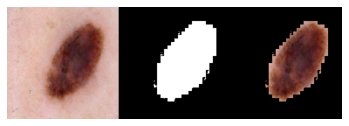

Epoch 70/70
 - 2s - loss: 0.0220 - mean_iou: 0.9553 - val_loss: 0.1225 - val_mean_iou: 0.9229
i= 70 loss= 0.02202116509188751 val_loss= 0.12250192761421204 mean_iou= 0.9552914324559664 val_mean_iou= 0.9228575229644775


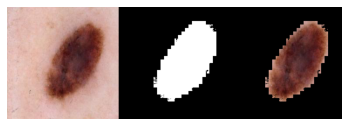

training time: 130.886549949646


In [ ]:
# train the model
import time

train_steps = len(train_files) //batch_size
test_steps = len(test_files) //batch_size
print(f'train_steps: {train_steps}')
print(f'test_steps: {test_steps}')

start = time.time()
model.fit_generator(train_generator, 
                    epochs = 70, steps_per_epoch = train_steps,validation_data = test_generator, validation_steps = test_steps,
                    callbacks = build_callbacks(), verbose = 2)
end = time.time()
print(f'training time: {end - start}')

In [ ]:
!zip unet-checkpoint-orig-100-100.zip unet.h5

  adding: unet.h5 (deflated 8%)


In [ ]:
weight_file = "./unet.h5"
model.load_weights(weight_file)

In [ ]:
# from https://valueml.com/iou-implementation-in-keras/

def mean_iou_test(y_true, y_pred):
    # inter = tf.count_nonzero(tf.logical_and(tf.equal(y_true, 1), tf.equal(y_pred, 1)))
    # union = tf.count_nonzero(tf.add(y_true, y_pred))
    # iou = tf.where(tf.equal(union, 0), 1., tf.cast(inter/union, 'float32'))
    # return iou
    axes = (0,1) 
    intersection = np.sum(y_pred * y_true, axis=axes) 
    mask = np.sum(y_true) + np.sum(y_pred, axis=axes)
    union = mask - intersection
    iou = intersection / union
    return iou

(1, 256, 256, 1)
[0 1]
[0. 1.]
iou: 0.6177730192719486


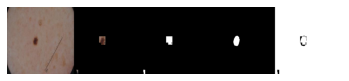

(1, 256, 256, 1)
[0 1]
[0. 1.]
iou: 0.8910499599251936


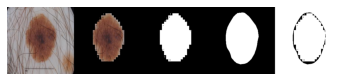

(1, 256, 256, 1)
[0 1]
[0. 1.]
iou: 0.601932811780948


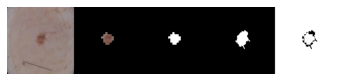

(1, 256, 256, 1)
[0 1]
[0. 1.]
iou: 0.6623815967523681


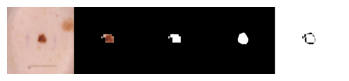

(1, 256, 256, 1)
[0 1]
[0. 1.]
iou: 0.7700305810397553


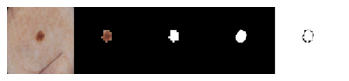

(1, 256, 256, 1)
[0 1]
[0. 1.]
iou: 0.5995525727069351


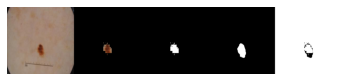

(1, 256, 256, 1)
[0 1]
[0. 1.]
iou: 0.3948576675849403


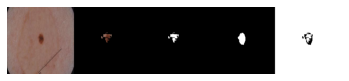

(1, 256, 256, 1)
[0 1]
[0. 1.]
iou: 0.7216411906677394


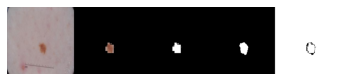

(1, 256, 256, 1)
[0 1]
[0. 1.]
iou: 0.727864746399499


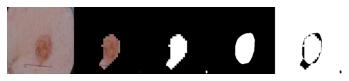

(1, 256, 256, 1)
[0 1]
[0. 1.]
iou: 0.008859157476044115


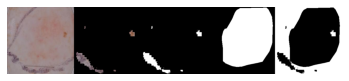

(1, 256, 256, 1)
[0 1]
[0. 1.]
iou: 0.7816666666666666


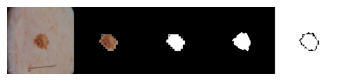

(1, 256, 256, 1)
[0 1]
[0. 1.]
iou: 0.0803182837297226


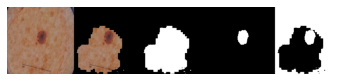

(1, 256, 256, 1)
[0 1]
[0. 1.]
iou: 0.658051689860835


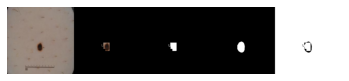

(1, 256, 256, 1)
[0 1]
[0. 1.]
iou: 0.3758589236850106


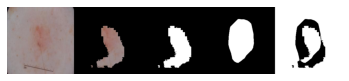

(1, 256, 256, 1)
[0 1]
[0. 1.]
iou: 0.4476933073424301


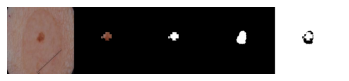

(1, 256, 256, 1)
[0 1]
[0. 1.]
iou: 0.03988671229643616


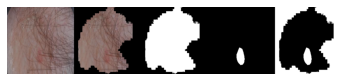

(1, 256, 256, 1)
[0 1]
[0. 1.]
iou: 0.6580907244414353


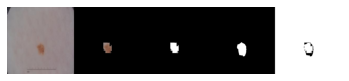

(1, 256, 256, 1)
[0 1]
[0. 1.]
iou: 0.34048140043763675


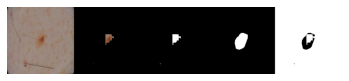

(1, 256, 256, 1)
[0 1]
[0. 1.]
iou: 0.5304054054054054


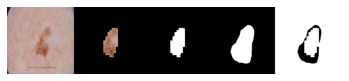

(1, 256, 256, 1)
[0 1]
[0. 1.]
iou: 0.39833220207505093


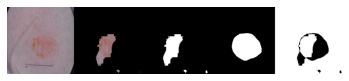

(1, 256, 256, 1)
[0 1]
[0. 1.]
iou: 0.44127405441274054


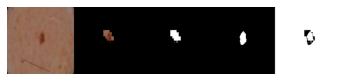

(1, 256, 256, 1)
[0 1]
[0. 1.]
iou: 0.7423043095866315


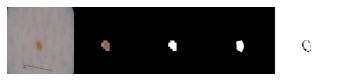

(1, 256, 256, 1)
[0 1]
[0. 1.]
iou: 0.6761565836298933


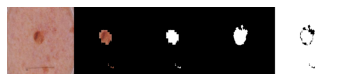

(1, 256, 256, 1)
[0 1]
[0. 1.]
iou: 0.4817987152034261


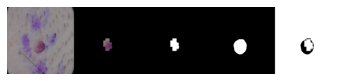

(1, 256, 256, 1)
[0 1]
[0. 1.]
iou: 0.07882766705744432


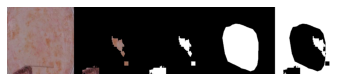

(1, 256, 256, 1)
[0 1]
[0. 1.]
iou: 0.6333819241982507


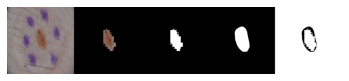

(1, 256, 256, 1)
[0 1]
[0. 1.]
iou: 0.45327192477451544


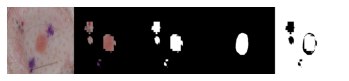

(1, 256, 256, 1)
[0 1]
[0. 1.]
iou: 0.8008083140877598


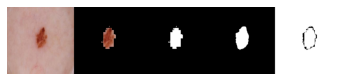

(1, 256, 256, 1)
[0 1]
[0. 1.]
iou: 0.4161686064800252


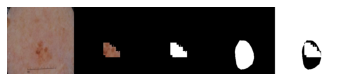

(1, 256, 256, 1)
[0 1]
[0. 1.]
iou: 0.7883720930232558


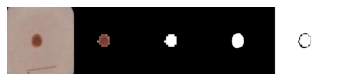

average iou: 0.53


In [ ]:
test_image = os.listdir('test-image-30')

sum = 0

for i in test_image:
  raw = Image.open(f'test-image-30/{i}')
  raw = np.array(raw.resize((256, 256)))/255.
  raw = raw[:,:,0:3]
  #predict the mask 
  pred = model.predict(np.expand_dims(raw, 0))
  print(pred.shape)
  #get intersection over union
  gt = Image.open(f'test-gt-30/{i[:-4]}.png')
  gt = np.array(gt)
  gt[gt > 0] = 1
  msk = msk.astype('uint8')
  #mask post-processing 
  msk  = pred.squeeze()
  msk[msk >= 0.5] = 1 
  msk[msk < 0.5] = 0 
  print(np.unique(gt))
  print(np.unique(msk))
  iou = mean_iou_test(gt, msk)
  sum += iou
  print(f'iou: {iou}')
  msk = np.stack((msk,)*3, axis=-1)
  gt = np.stack((gt,)*3, axis=-1)
  #show the mask and the segmented image 
  combined = np.concatenate([raw, raw * msk, msk, gt, gt == msk], axis = 1)
  plt.axis('off')
  plt.imshow(combined)
  plt.show()

print(f'average iou: {sum/len(test_image):.2f}')